## Находим путь Дюбинса между двумя точками

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot

show_animation = True


def dubins_path_planning(s_x, s_y, s_yaw, g_x, g_y, g_yaw, curvature,
                         step_size=1):
    """
    Dubins path planner
    :param s_x: x position of start point [m]
    :param s_y: y position of start point [m]
    :param s_yaw: yaw angle of start point [rad]
    :param g_x: x position of end point [m]
    :param g_y: y position of end point [m]
    :param g_yaw: yaw angle of end point [rad]
    :param curvature: curvature for curve [1/m]
    :param step_size: (optional) step size between two path points [m]
    :return:
        x_list: x positions of a path
        y_list: y positions of a path
        yaw_list: yaw angles of a path
        modes: mode list of a path
        lengths: length of path segments.
    """

    g_x -= s_x
    g_y -= s_y

    l_rot = Rot.from_euler('z', s_yaw).as_matrix()[0:2, 0:2]
    le_xy = np.stack([g_x, g_y]).T @ l_rot
    le_yaw = g_yaw - s_yaw

    lp_x, lp_y, lp_yaw, modes, lengths = dubins_path_planning_from_origin(
        le_xy[0], le_xy[1], le_yaw, curvature, step_size)

    rot = Rot.from_euler('z', -s_yaw).as_matrix()[0:2, 0:2]
    converted_xy = np.stack([lp_x, lp_y]).T @ rot
    x_list = converted_xy[:, 0] + s_x
    y_list = converted_xy[:, 1] + s_y
    yaw_list = [pi_2_pi(i_yaw + s_yaw) for i_yaw in lp_yaw]

    return x_list, y_list, yaw_list, modes, lengths


def mod2pi(theta):
    return theta - 2.0 * math.pi * math.floor(theta / 2.0 / math.pi)


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


def lsl(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    tmp0 = d + sa - sb

    mode = ["L", "S", "L"]
    p_squared = 2 + (d * d) - (2 * c_ab) + (2 * d * (sa - sb))
    if p_squared < 0:
        return None, None, None, mode
    tmp1 = math.atan2((cb - ca), tmp0)
    t = mod2pi(-alpha + tmp1)
    p = math.sqrt(p_squared)
    q = mod2pi(beta - tmp1)

    return t, p, q, mode


def rsr(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    tmp0 = d - sa + sb
    mode = ["R", "S", "R"]
    p_squared = 2 + (d * d) - (2 * c_ab) + (2 * d * (sb - sa))
    if p_squared < 0:
        return None, None, None, mode
    tmp1 = math.atan2((ca - cb), tmp0)
    t = mod2pi(alpha - tmp1)
    p = math.sqrt(p_squared)
    q = mod2pi(-beta + tmp1)

    return t, p, q, mode


def lsr(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    p_squared = -2 + (d * d) + (2 * c_ab) + (2 * d * (sa + sb))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    p = math.sqrt(p_squared)
    tmp2 = math.atan2((-ca - cb), (d + sa + sb)) - math.atan2(-2.0, p)
    t = mod2pi(-alpha + tmp2)
    q = mod2pi(-mod2pi(beta) + tmp2)

    return t, p, q, mode


def rsl(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    p_squared = (d * d) - 2 + (2 * c_ab) - (2 * d * (sa + sb))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    p = math.sqrt(p_squared)
    tmp2 = math.atan2((ca + cb), (d - sa - sb)) - math.atan2(2.0, p)
    t = mod2pi(alpha - tmp2)
    q = mod2pi(beta - tmp2)

    return t, p, q, mode


def rlr(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    mode = ["R", "L", "R"]
    tmp_rlr = (6.0 - d * d + 2.0 * c_ab + 2.0 * d * (sa - sb)) / 8.0
    if abs(tmp_rlr) > 1.0:
        return None, None, None, mode

    p = mod2pi(2 * math.pi - math.acos(tmp_rlr))
    t = mod2pi(alpha - math.atan2(ca - cb, d - sa + sb) + mod2pi(p / 2.0))
    q = mod2pi(alpha - beta - t + mod2pi(p))
    return t, p, q, mode


def lrl(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    mode = ["L", "R", "L"]
    tmp_lrl = (6.0 - d * d + 2.0 * c_ab + 2.0 * d * (- sa + sb)) / 8.0
    if abs(tmp_lrl) > 1:
        return None, None, None, mode
    p = mod2pi(2 * math.pi - math.acos(tmp_lrl))
    t = mod2pi(-alpha - math.atan2(ca - cb, d + sa - sb) + p / 2.0)
    q = mod2pi(mod2pi(beta) - alpha - t + mod2pi(p))

    return t, p, q, mode


def dubins_path_planning_from_origin(end_x, end_y, end_yaw, curvature,
                                     step_size):
    dx = end_x
    dy = end_y
    D = math.hypot(dx, dy)
    d = D * curvature

    theta = mod2pi(math.atan2(dy, dx))
    alpha = mod2pi(- theta)
    beta = mod2pi(end_yaw - theta)

    planning_funcs = [lsl, rsr,lsr, rsl,rlr, lrl]

    best_cost = float("inf")
    bt, bp, bq, best_mode = None, None, None, None

    for planner in planning_funcs:
        t, p, q, mode = planner(alpha, beta, d)
        if t is None:
            continue

        cost = (abs(t) + abs(p) + abs(q))
        if best_cost > cost:
            bt, bp, bq, best_mode = t, p, q, mode
            best_cost = cost
    lengths = [bt, bp, bq]

    x_list, y_list, yaw_list, directions = generate_local_course(sum(lengths),
                                                                 lengths,
                                                                 best_mode,
                                                                 curvature,
                                                                 step_size)

    lengths = [length / curvature for length in lengths]

    return x_list, y_list, yaw_list, best_mode, lengths


def interpolate(ind, length, mode, max_curvature, origin_x, origin_y,
                origin_yaw, path_x, path_y, path_yaw, directions):
    if mode == "S":
        path_x[ind] = origin_x + length / max_curvature * math.cos(origin_yaw)
        path_y[ind] = origin_y + length / max_curvature * math.sin(origin_yaw)
        path_yaw[ind] = origin_yaw
    else:  # curve
        ldx = math.sin(length) / max_curvature
        ldy = 0.0
        if mode == "L":  # left turn
            ldy = (1.0 - math.cos(length)) / max_curvature
        elif mode == "R":  # right turn
            ldy = (1.0 - math.cos(length)) / -max_curvature
        gdx = math.cos(-origin_yaw) * ldx + math.sin(-origin_yaw) * ldy
        gdy = -math.sin(-origin_yaw) * ldx + math.cos(-origin_yaw) * ldy
        path_x[ind] = origin_x + gdx
        path_y[ind] = origin_y + gdy

    if mode == "L":  # left turn
        path_yaw[ind] = origin_yaw + length
    elif mode == "R":  # right turn
        path_yaw[ind] = origin_yaw - length

    if length > 0.0:
        directions[ind] = 1
    else:
        directions[ind] = -1

    return path_x, path_y, path_yaw, directions


def generate_local_course(total_length, lengths, modes, max_curvature,
                          step_size):
    n_point = math.trunc(total_length / step_size) + len(lengths) + 4

    p_x = [0.0 for _ in range(n_point)]
    p_y = [0.0 for _ in range(n_point)]
    p_yaw = [0.0 for _ in range(n_point)]
    directions = [0.0 for _ in range(n_point)]
    ind = 1

    if lengths[0] > 0.0:
        directions[0] = 1
    else:
        directions[0] = -1

    ll = 0.0

    for (m, length, i) in zip(modes, lengths, range(len(modes))):
        if length == 0.0:
            continue
        elif length > 0.0:
            dist = step_size
        else:
            dist = -step_size

        # set origin state
        origin_x, origin_y, origin_yaw = p_x[ind], p_y[ind], p_yaw[ind]

        ind -= 1
        if i >= 1 and (lengths[i - 1] * lengths[i]) > 0:
            pd = - dist - ll
        else:
            pd = dist - ll

        while abs(pd) <= abs(length):
            ind += 1
            p_x, p_y, p_yaw, directions = interpolate(ind, pd, m,
                                                      max_curvature,
                                                      origin_x,
                                                      origin_y,
                                                      origin_yaw,
                                                      p_x, p_y,
                                                      p_yaw,
                                                      directions)
            pd += dist

        ll = length - pd - dist  # calc remain length

        ind += 1
        p_x, p_y, p_yaw, directions = interpolate(ind, length, m,
                                                  max_curvature,
                                                  origin_x, origin_y,
                                                  origin_yaw,
                                                  p_x, p_y, p_yaw,
                                                  directions)

    if len(p_x) <= 1:
        return [], [], [], []

    # remove unused data
    while len(p_x) >= 1 and p_x[-1] == 0.0:
        p_x.pop()
        p_y.pop()
        p_yaw.pop()
        directions.pop()

    return p_x, p_y, p_yaw, directions


def plot_arrow(x, y, yaw, length=1.0, width=0.5, fc="r",
               ec="k"):  # pragma: no cover
    if not isinstance(x, float):
        for (i_x, i_y, i_yaw) in zip(x, y, yaw):
            plot_arrow(i_x, i_y, i_yaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw), fc=fc,
                  ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)


def build_dubins(start_x,start_y,start_yaw,end_x,end_y,end_yaw,step_size=1):

#     start_x = 1.0  # [m]
#     start_y = 1.0  # [m]
#     start_yaw = np.deg2rad(45.0)  # [rad]

#     end_x = -3.0  # [m]
#     end_y = -3.0  # [m]
#     end_yaw = np.deg2rad(-45.0)  # [rad]

    curvature = 1.0

    path_x, path_y, path_yaw, mode, lengths = dubins_path_planning(start_x,
                                                                   start_y,
                                                                   start_yaw,
                                                                   end_x,
                                                                   end_y,
                                                                   end_yaw,
                                                                   curvature,
                                                                   step_size)

    if show_animation:
        plt.plot(path_x, path_y, label="final course " + "".join(mode))

        # plotting
        plot_arrow(start_x, start_y, start_yaw)
        plot_arrow(end_x, end_y, end_yaw)

        plt.legend()
        plt.grid(True)
        plt.axis("equal")
        plt.show()
    

## Для отрисовки полученного результата

In [3]:
def plot_arrow(x, y, yaw, length=0.3, width=0.15, fc="orange",
               ec="orange"):
    if not isinstance(x, float):
        for (i_x, i_y, i_yaw) in zip(x, y, yaw):
            plot_arrow(i_x, i_y, i_yaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw), fc=fc,
                  ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)


def draw_graph(graph):
    x = [i[0] for i in graph]
    y = [i[1] for i in graph]
    yaw = [i[2] for i in graph]
    plt.scatter(x,y,color='blue',s=20)
    try:
        plot_arrow(x,y,yaw)
    except:
        pass


def draw_obstacles(obstacles,n):
    for i in range(n):
        obs = obstacles[i]['points']
        x = obs[0]
        y = obs[1]
        plt.plot(x, y,'r')

def draw_path(pathes,points):
    for point in points:
        if (point[0],point[1]) in pathes:
            plt.plot(pathes[(point[0],point[1])][0],pathes[(point[0],point[1])][1],
                 '-o',markersize = '2',linewidth=0.5,color='green')
    
def draw_pathes(graph,pathes):
    for i in pathes.keys():
        plt.plot(pathes[(i[0],i[1])][0],pathes[(i[0],i[1])][1],'-o',markersize = '1.5',linewidth=0.3,color='black')



def picture(for_picture):
    bordersize,start,finish,obstacles,num_obs,graph,parent,pathes,points = for_picture
    plt.figure(figsize=(10,10),dpi=100)
    draw_obstacles(obstacles,num_obs)
    draw_graph(graph)
    draw_pathes(graph,pathes)
    draw_path(pathes,points)
    plt.plot(start[0],start[1], marker="o",markersize = '7', mec="green",mfc = 'green')
    plt.plot(finish[0],finish[1], marker="o",markersize = '7', mec="red",mfc = 'red')
    plot_arrow(start[0],start[1],start[2],fc='g',ec='g')
    plot_arrow(finish[0],finish[1],finish[2],fc='r',ec='r')
    plt.axis(bordersize)
    plt.xticks(range(bordersize[0],bordersize[1]))
    plt.yticks(range(bordersize[2],bordersize[3]))
    plt.grid()
    plt.show()

## Реализация RRT + Dubins curve

In [22]:
import yaml
from pprint import pprint
import matplotlib.pyplot as plt
import random
import math
from matplotlib.pyplot import figure
from collections import defaultdict
from shapely.geometry import Point, Polygon,LineString
import time

#data_for_animation = []

#random.seed(11)

def read(name):
    with open(name) as f:
        templates = yaml.safe_load(f)
        bordersize = templates['bordersize']
        num_obs = templates['num_obstacles']
        obstacles = templates['obstacles']
    return bordersize,num_obs,obstacles

def read_initial_points(name):
    with open(name) as f:
        templates = yaml.safe_load(f)
        start = templates['start']
        finish = templates['finish']
    return start,finish

def distance(a,b,x,y):
    return math.sqrt((a-x)**2 + (b-y)**2)


def find_nearest_vertex_rrt(g,x,y):
    min_dist = 10000000
    v_x = 0
    v_y = 0
    v_angle = 0
    for vert in g:
        a = distance(vert[0],vert[1],x,y)
        if a<min_dist:
            min_dist = a
            v_x = vert[0]
            v_y = vert[1]
            v_angle = vert[2]
    return [v_x,v_y,v_angle]

def find_nearest_vertex_rrt_star(g,x,y,neighbourhood_dist):
    neighbourhood = []
    for vert in g:
        a = distance(vert[0],vert[1],x,y)
        if a<neighbourhood_dist:
            neighbourhood.append([vert,a])
    return neighbourhood

def move(p1,p2,dist,step_size = 0.5,curvature = 1):
    path_x,path_y,path_yaw,_,length = dubins_path_planning(p1[0],p1[1],p1[2],
                                                  p2[0],p2[1],p2[2],
                                                  curvature,step_size)
    s = 0
    i = 0
    
    while s<dist and s<sum(length) and i<len(path_x)-1:
        s+=distance(path_x[i],path_y[i],path_x[i+1],path_y[i+1])
        i+=1
    
    new_path_x = path_x[:i+1]
    new_path_y = path_y[:i+1]
    p = [path_x[i],path_y[i],path_yaw[i]]
    return p,new_path_x,new_path_y,

def check_points(x, y,obstacles):
    p = Point((x,y))
    for obs in obstacles: 
        a = obs['points'][0]
        b = obs['points'][1]
        z = [(a[i],b[i]) for i in range(1,len(a))]
        poly = Polygon(z)
        if (poly.contains(p)) or (poly.touches(p)):
            return True
    return False

def check_borders(bordersize,vert):
    x = vert[0]
    y = vert[1]
    if x<=bordersize[0] or x>=bordersize[1]:
        return True
    if y<=bordersize[2] or y>=bordersize[3]:
        return True
    return False

def check_final(a,b,radius):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 < radius**2

def build_path(graph,parent,final,start):
    path = []
    q = final
    while not(q[0]== start[0] and q[1]==start[1]):
        path.append(q)
        q = parent[(q[0],q[1])]
    path.append(start)
    return path
def find_this_path(points,pathes):
    cur_path_x = []
    cur_path_y = []
    for point in points:
        current_path = pathes[(point[0],point[1])]
        cur_path_x += current_path[0]
        cur_path_y += current_path[1]
    path = [cur_path_x,cur_path_y]
    return path

def calculate_len(pathes,points):
    length = 0
    for point in points:
        if (point[0],point[1]) in pathes:
            path = pathes[(point[0],point[1])]
            for i in range(len(path[0])-1):
                length +=distance(path[0][i],path[1][i],path[0][i+1],path[1][i+1])
    return length

    
def check_path_intersection(path,obstacles):
    if len(path[0])>1:
        for e in range(len(path[0])-1):
            p1 = [path[0][e],path[1][e]]
            p2 = [path[0][e+1],path[1][e+1]]
            edge = LineString([p1,p2])
            for obs in obstacles:
                x = obs['points'][0]
                y = obs['points'][1]
                for i in range(1,len(x)):
                    a = Point((x[i-1]),(y[i-1]))
                    b = Point((x[i]),(y[i]))
                    line = LineString([a,b])
                    if (edge.intersects(line)) or (edge.touches(line)):
                        return True
 
    return False

def rrt(bordersize,start,finish,num_obs,obstacles,dist,steps,radius,step_dubins,curvature):
    # dist - длина каждого шага
    pathes = {}
    sequnce_of_points = []
    graph = []
    graph.append(start)
    parent = {}
    final_point = 0
    mindist = radius
    number_of_vertices = 0
    path = []
    
    while number_of_vertices<steps: 
        x = round(random.uniform(bordersize[0],bordersize[1]),3)
        y = round(random.uniform(bordersize[2],bordersize[3]),3)
        phi = round(random.uniform(-180,180),3)
        near_point = find_nearest_vertex_rrt(graph,x,y)
        new_vert,new_path_x,new_path_y = move(near_point,[x,y,phi],dist,step_dubins,curvature)
        number_of_vertices+=1
        if check_borders(bordersize,new_vert):
            continue
        if check_points(new_vert[0],new_vert[1],obstacles):
            continue
        #Проверка пересекает ли новое ребро граф
        if check_path_intersection([new_path_x,new_path_y],obstacles):
            continue
        graph.append(new_vert)
        if (check_final(finish,new_vert,radius)) and (distance(finish[0],finish[1],new_vert[0],new_vert[1])<mindist):
            final_point = new_vert
            mindist = distance(finish[0],finish[1],new_vert[0],new_vert[1])
        parent[(new_vert[0],new_vert[1])] = (near_point[0],near_point[1])
        pathes[(new_vert[0],new_vert[1])] = ([new_path_x,new_path_y])
        if final_point!=0: 
            break
    if final_point!=0: #We are looking for the points which are the right path
        sequnce_of_points = build_path(graph,parent,final_point,start)
        
    return graph,parent,number_of_vertices,sequnce_of_points,pathes

def main(map_name,steer,step_dubins,curvature,tolerance,epochs,how_input = 'file', algorithm='rrt'):
    if how_input == 'file':
        [start,finish] = read_initial_points('points_dubins.yaml')
        [bordersize,num_obs,obstacles] = read(map_name)
        for i in range(len(start)):
            print(i)
            if algorithm == 'rrt':
                graph,parent,number_of_vertices,points,pathes = rrt(bordersize,start[i],finish[i],num_obs,obstacles,steer,epochs,tolerance,step_dubins,curvature)
            else:
                graph,parent,number_of_vertices,points,pathes = rrt_star(bordersize,start[i],finish[i],num_obs,obstacles,steer,epochs,tolerance,step_dubins,curvature)
            for_picture = [bordersize,start[i],finish[i],obstacles,num_obs,graph,parent,pathes,points]
            if points:
                print('Found path, length: '+ str(calculate_len(pathes,points)))
                print('Number of vertices: '+ str(number_of_vertices))

            else:
                print('NO PATH')
            picture(for_picture)

    if how_input == 'console':
        start = [float(i) for i in input('Enter initial coordinates and angle split by space: ').split()]
        finish = [float(i) for i in input('Enter finial coordinates and angle split by space: ').split()]
        [bordersize,num_obs,obstacles] = read(map_name)
        if algorithm == 'rrt':
            graph,parent,number_of_vertices,points,pathes = rrt(bordersize,start,finish,num_obs,obstacles,steer,epochs,tolerance,step_dubins,curvature)
        else:
            graph,parent,number_of_vertices,points,pathes = rrt_star(bordersize,start,finish,num_obs,obstacles,steer,epochs,tolerance,step_dubins,curvature)
        for_picture = [bordersize,start,finish,obstacles,num_obs,graph,parent,pathes,points]
        if points:
            print ('Found path, length: '+ str(calculate_len(pathes,points)))
            print('Number of vertices: '+ str(number_of_vertices))

        else:
            print('NO PATH')
        picture(for_picture)
        return for_picture

Функция на вход принимает:
- файл, с размеченной картой,
- максимальную длину шага(steer),
- шаг для интерполяции кривой Дюбинса(step_dubins),
- кривизна - обратная к радиусу поворота (curvature),
- радиус попадания в финальную точку(tolerance),
- количество шагов(epochs),
- какой вход начальных данных - с консоли или с файла (how_input, возможные варианты: console, file), 
Возможно появится реализация алгоритма RRTstar

Enter initial coordinates and angle split by space: 9 9 45
Enter finial coordinates and angle split by space: -9 -9 -45
Found path, length: 33.64576025117565
Number of vertices: 338


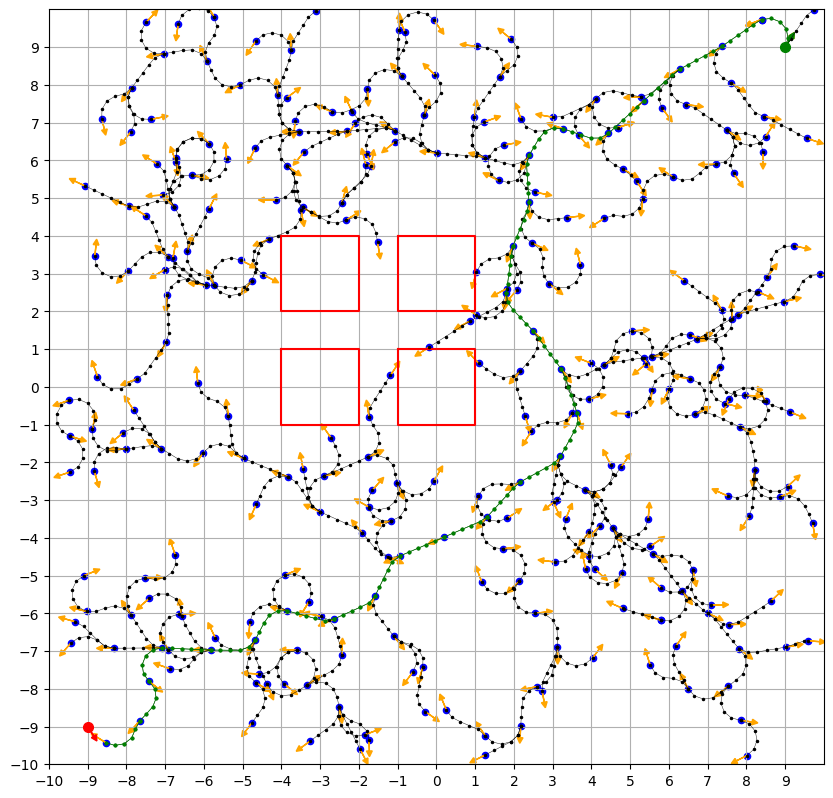

--- 9.204796075820923 seconds ---


In [24]:
start_time = time.time()
w = main(map_name = 'input2.yaml',steer = 1,
         step_dubins = 0.5, curvature = 2,tolerance = 0.9,
         epochs = 1000, how_input = 'console', algorithm = 'rrt')
print("--- %s seconds ---" % (time.time() - start_time))